In [ ]:
#testing version control


In [361]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import statsmodels.api as sm
import math

In [362]:
# input the stock ticker we wana study
stock_ticker = "TSLA"
current_date = '2025-04-15'
maturity_date = '2025-04-25'
option_type = 'call' 

In [363]:
# read option chain file
df = pd.read_excel('Combined_' + stock_ticker + '_options_15-Apr-25.xlsx')

In [364]:
# Function to get option chain in the dataframe
# Select option chain with specific current date and maturity date
def get_option_chain(df_input, symbol_input, direction, current_date_input, maturity_date_input=None):
    # Ignore maturity date when the user doesn't put in a maturity date
    condition = (df_input["Symbol"] == symbol_input) & (df_input['Direction'] == direction) & (df_input['Current Date'] == current_date_input)
    # Filter with maturity date when the user put in a maturity date
    if not maturity_date_input is None:
        condition = condition & (df_input['Expiration Date'] == maturity_date_input)
    df_res = df_input[condition]
    return df_res

# Function to perform linear regression with list of columns as input, using sm.OLS
def linear_regression(df_input, y_col, x_cols):
    df = df_input
    X = df[x_cols]
    y = df[y_col]
    X = sm.add_constant(X)  # Adds a constant term to the predictor
    model = sm.OLS(y, X).fit()
    return model

# Define a function to plot the IVM across moneyness with maturity in the legend
def plot_ivm_across_moneyness(df_input, symbol_input, direction_input, current_date_input):

    # Filter the data for the specified stock, direction, and date
    df_target = get_option_chain(df_input, symbol_input, direction_input, current_date_input)
    
    # Group by maturity (time_to_maturity_years)
    grouped = df_target.groupby('time_to_maturity_years')
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    for maturity, group in grouped:
        plt.scatter(group['moneyness'], group['IVM'], label=f'Maturity: {maturity:.2f} years')
    
    # Add labels, title, legend, and grid
    plt.xlabel('Moneyness')
    plt.ylabel('IVM')
    plt.title(f'IVM across Moneyness for {symbol_input} {direction_input} options on {current_date_input}')
    plt.legend(title='Maturity (years)', loc='best')
    plt.grid()
    plt.show()

# Function to plot 3D graph of IVM across moneyness and time_to_maturity_years
def plot_ivm_across_moneyness_and_days(df, symbol_input, direction, current_date_input):

    # Get the filtered option chain
    df_target = get_option_chain(df, symbol_input, direction, current_date_input)
    
    # Create the 3D plot
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(df_target['moneyness'], 
               df_target['time_to_maturity_years'], 
               df_target['IVM'], 
               color='blue')
    
    # Set labels and title
    ax.set_xlabel('Moneyness')
    ax.set_ylabel('Time to Maturity (in years)')
    ax.set_zlabel('IVM')
    ax.set_title(f'IVM across Moneyness and Time to Maturity for {symbol_input} {direction} options on {current_date_input}')
    
    # Show the plot
    plt.show()

# Function to input current stock price, strike, maturity date and direction, then output moneyess, time_to_maturity_years,'moneyness_squared', 'maturity_squared', 'moneyness_maturity' in list
def get_warrant_moneyness_expiration(current_stock_price, strike, maturity_date_input, current_date_input):
    # Convert dates to datetime format
    current_date = pd.to_datetime(current_date_input)
    maturity_date = pd.to_datetime(maturity_date_input)
    
    # Calculate moneyness and time_to_maturity_years
    moneyness = current_stock_price / strike
    time_to_expiration_days = (maturity_date - current_date).days
    time_to_expiration_years = time_to_expiration_days / 365
    
    # Calculate squares and products
    moneyness_squared = moneyness ** 2
    maturity_squared = time_to_expiration_years ** 2
    moneyness_maturity = moneyness * time_to_expiration_years
    
    return [moneyness, time_to_expiration_years, moneyness_squared, maturity_squared, moneyness_maturity]


In [365]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11199 entries, 0 to 11198
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Ticker                    11199 non-null  object 
 1   Symbol                    11199 non-null  object 
 2   Expiration Date           11199 non-null  object 
 3   Strike                    11199 non-null  float64
 4   Bid                       11199 non-null  float64
 5   Ask                       11199 non-null  float64
 6   Last                      11199 non-null  float64
 7   IVM                       11199 non-null  float64
 8   Direction                 11199 non-null  object 
 9   Current Date              11199 non-null  object 
 10  Current Date Stock Price  11199 non-null  float64
dtypes: float64(6), object(5)
memory usage: 962.5+ KB


In [366]:
#show unique values in "Expiration Date" in ascending order
date_count = df["Expiration Date"].value_counts().reset_index()
date_count["Expiration Date"] = pd.to_datetime(date_count["Expiration Date"])
date_count.set_index("Expiration Date", inplace=True)
date_count = date_count.sort_index()
date_count

,count
Expiration Date,
2025-01-17,880
2025-02-21,2720
2025-03-21,3359
2025-04-17,2880
2025-04-25,160
2025-05-16,1200


In [367]:
# Remove rows where "IVM" is 0
df = df[df['IVM']!=0]

In [368]:
# Add columns for regression

# Ensure 'Expiration Date' and 'Current Date' are in datetime format
df['Expiration Date'] = pd.to_datetime(df['Expiration Date'])
df['Current Date'] = pd.to_datetime(df['Current Date'])

# Add moneyness
df['moneyness'] = df['Current Date Stock Price'] / df['Strike']

# Add time_to_maturity_days
df['time_to_maturity_days'] = (df['Expiration Date'] - df['Current Date']).dt.days

# Add 'days_to_expiration' in years
df['time_to_maturity_years'] = df['time_to_maturity_days'] / 365

# Add a column 'moneyness square'
df['moneyness_squared'] = df['moneyness'] ** 2

# Add a column 'maturity_squared'
df['maturity_squared'] = df['time_to_maturity_years'] ** 2

df['moneyness_maturity']= df['moneyness'] * df['time_to_maturity_years']

df['log_IVM'] = np.log(df['IVM']/100)

col_order = ['Ticker', 'Symbol', 'Current Date', 'Expiration Date', 'time_to_maturity_days', 'time_to_maturity_years', 'Current Date Stock Price', 'Strike', 'Bid', 'Ask', 'Last',
       'IVM', 'Direction', 'moneyness', 'moneyness_squared', 'maturity_squared', 'moneyness_maturity', 'log_IVM']
df = df.loc[:, col_order]

df.head()

,Ticker,Symbol,Current Date,Expiration Date,time_to_maturity_days,time_to_maturity_years,Current Date Stock Price,Strike,Bid,Ask,Last,IVM,Direction,moneyness,moneyness_squared,maturity_squared,moneyness_maturity,log_IVM
0,TSLA 4/17/25 P292.5,TSLA,2025-04-01,2025-04-17,16,0.043836,268.459991,292.5,29.300003,29.750000,30.699997,66.453506,put,0.917812,0.842379,0.001922,0.040233,-0.408668
1,TSLA 4/17/25 P275,TSLA,2025-04-01,2025-04-17,16,0.043836,268.459991,275.0,18.649994,18.800003,19.800003,69.441322,put,0.976218,0.953002,0.001922,0.042793,-0.364688
2,TSLA 4/17/25 P277.5,TSLA,2025-04-01,2025-04-17,16,0.043836,268.459991,277.5,19.899994,20.199997,21.240005,68.867378,put,0.967423,0.935908,0.001922,0.042408,-0.372988
3,TSLA 4/17/25 P280,TSLA,2025-04-01,2025-04-17,16,0.043836,268.459991,280.0,21.250000,21.600006,22.800003,68.224792,put,0.958786,0.919270,0.001922,0.042029,-0.382362
4,TSLA 4/17/25 P282.5,TSLA,2025-04-01,2025-04-17,16,0.043836,268.459991,282.5,22.800003,23.149994,24.149994,68.040154,put,0.950301,0.903072,0.001922,0.041657,-0.385072


In [369]:
# Select the option chain for a specific stock, direction, and current date and maturity date
df_target = get_option_chain(df, stock_ticker, option_type, current_date, maturity_date)

# Define the dependent and independent variables
# dependent_var = 'log_IVM'  # USE log IVM
dependent_var = 'IVM' # without take log
independent_vars = ['moneyness', 'time_to_maturity_years', 'moneyness_squared', 'maturity_squared', 'moneyness_maturity'] # we set the regressor

# Perform linear regression
regression_summary = linear_regression(df_target, dependent_var, independent_vars).summary()

# Display the regression summary
print(regression_summary)

                            OLS Regression Results                            
Dep. Variable:                    IVM   R-squared:                       0.788
Model:                            OLS   Adj. R-squared:                  0.776
Method:                 Least Squares   F-statistic:                     68.65
Date:                Sat, 19 Apr 2025   Prob (F-statistic):           3.53e-13
Time:                        16:43:37   Log-Likelihood:                -92.140
No. Observations:                  40   AIC:                             190.3
Df Residuals:                      37   BIC:                             195.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
moneyness                217

In [370]:
# print(df_new[['IVM']])

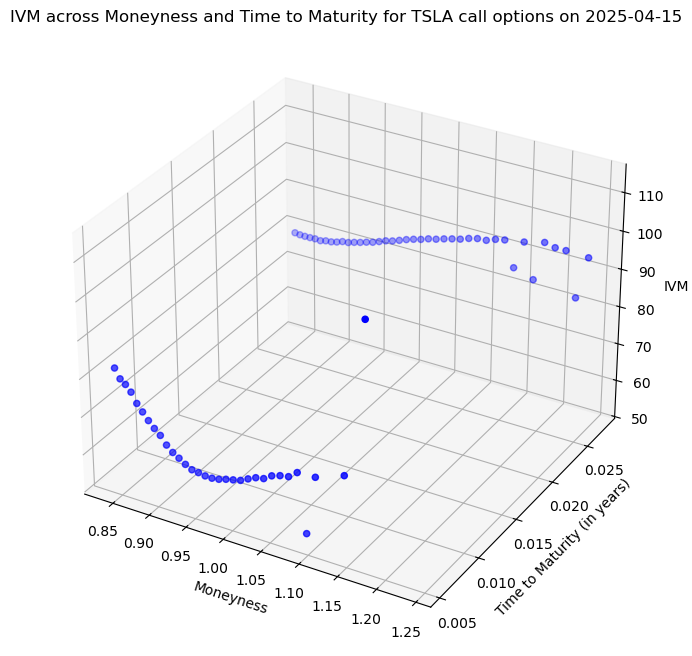

In [371]:
plot_ivm_across_moneyness_and_days(df, stock_ticker, 'call', current_date)  #show call volatility smile

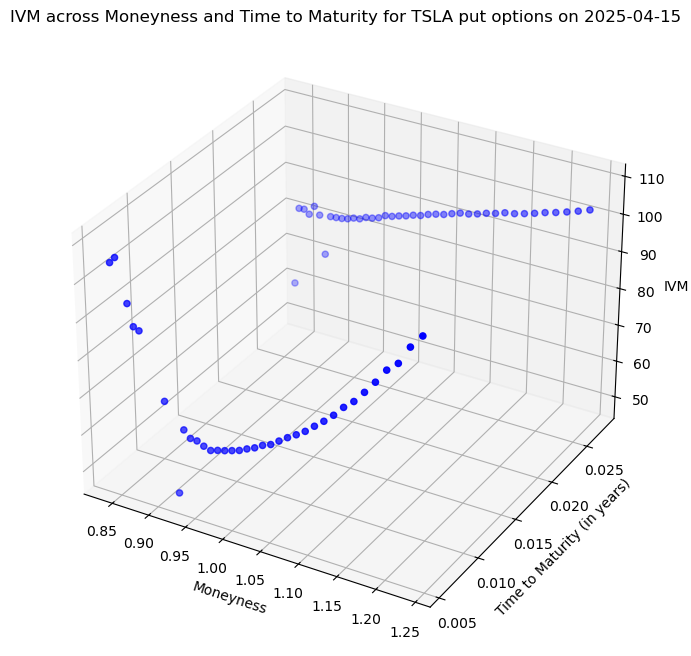

In [372]:
plot_ivm_across_moneyness_and_days(df, stock_ticker, 'put', current_date)  # show put volatility smile

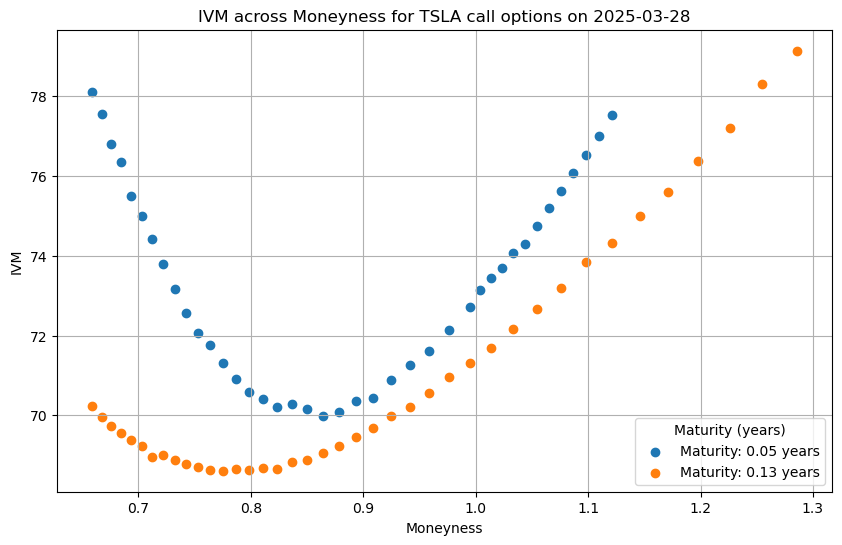

In [373]:
plot_ivm_across_moneyness(df, stock_ticker, 'call', '2025-03-28')  # show call volatility smileb

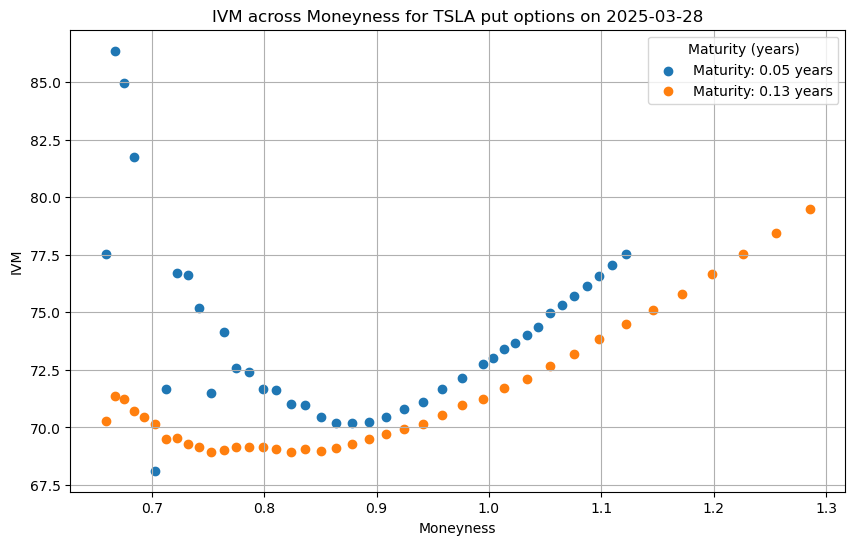

In [374]:
plot_ivm_across_moneyness(df, stock_ticker, 'put', '2025-03-28')  # show put volatility smile

We test with the following regression models, letting $K$ be moneyness, $T$ be time to maturity, $K*T$ be moneyness_maturity, $K^2$ be moneyness squared and $T^2$ be maturity squared.

- Model 1: $K, T, K*T$
- Model 2: $K, T, K^2$
- Model 3: $K, T, T^2$
- Model 4: $K, T, K^2, K*T$
- Model 5: $K, T, T^2, K*T$
- Model 6: $K, T, K^2, T^2, K*T$

In [375]:
# Function to perform linear regression with list of columns as input, using sm.OLS
# model1: K,T,K*T

independent_vars_one = ['moneyness', 'time_to_maturity_years', 'moneyness_maturity'] # model1: K,T,K*T
model = linear_regression(df_target, dependent_var, independent_vars_one)


print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    IVM   R-squared:                       0.746
Model:                            OLS   Adj. R-squared:                  0.739
Method:                 Least Squares   F-statistic:                     111.4
Date:                Sat, 19 Apr 2025   Prob (F-statistic):           7.43e-13
Time:                        16:43:43   Log-Likelihood:                -95.752
No. Observations:                  40   AIC:                             195.5
Df Residuals:                      38   BIC:                             198.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
moneyness                 38

In [376]:
# Function to perform linear regression with list of columns as input, using sm.OLS
# model2: K,T,K^2

independent_vars_two = ['moneyness', 'time_to_maturity_years', 'moneyness_squared'] # model2: K,T,K^2
model = linear_regression(df_target, dependent_var, independent_vars_two)


print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    IVM   R-squared:                       0.788
Model:                            OLS   Adj. R-squared:                  0.776
Method:                 Least Squares   F-statistic:                     68.65
Date:                Sat, 19 Apr 2025   Prob (F-statistic):           3.53e-13
Time:                        16:43:43   Log-Likelihood:                -92.140
No. Observations:                  40   AIC:                             190.3
Df Residuals:                      37   BIC:                             195.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
moneyness                217

In [377]:
# Function to perform linear regression with list of columns as input, using sm.OLS
# model3: K,T,T^2

independent_vars_three = ['moneyness', 'time_to_maturity_years', 'maturity_squared'] # model3: K,T,T^2
model = linear_regression(df_target, dependent_var, independent_vars_three)


print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    IVM   R-squared:                       0.746
Model:                            OLS   Adj. R-squared:                  0.739
Method:                 Least Squares   F-statistic:                     111.4
Date:                Sat, 19 Apr 2025   Prob (F-statistic):           7.43e-13
Time:                        16:43:43   Log-Likelihood:                -95.752
No. Observations:                  40   AIC:                             195.5
Df Residuals:                      38   BIC:                             198.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
moneyness                 38

In [378]:
# Function to perform linear regression with list of columns as input, using sm.OLS
# model4: K,T,K^2,K*T

independent_vars_four = ['moneyness', 'time_to_maturity_years', 'moneyness_squared', 'moneyness_maturity'] # model4: K,T,K^2,K*T
model = linear_regression(df_target, dependent_var, independent_vars_four)


print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    IVM   R-squared:                       0.788
Model:                            OLS   Adj. R-squared:                  0.776
Method:                 Least Squares   F-statistic:                     68.65
Date:                Sat, 19 Apr 2025   Prob (F-statistic):           3.53e-13
Time:                        16:43:44   Log-Likelihood:                -92.140
No. Observations:                  40   AIC:                             190.3
Df Residuals:                      37   BIC:                             195.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
moneyness                217

In [379]:
# Function to perform linear regression with list of columns as input, using sm.OLS
# model5 K,T,T^2,K*T

independent_vars_five = ['moneyness', 'time_to_maturity_years','maturity_squared','moneyness_maturity'] # model5 K,T,T^2,K*T
model = linear_regression(df_target, dependent_var, independent_vars_five)


print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    IVM   R-squared:                       0.746
Model:                            OLS   Adj. R-squared:                  0.739
Method:                 Least Squares   F-statistic:                     111.4
Date:                Sat, 19 Apr 2025   Prob (F-statistic):           7.43e-13
Time:                        16:43:44   Log-Likelihood:                -95.752
No. Observations:                  40   AIC:                             195.5
Df Residuals:                      38   BIC:                             198.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
moneyness                 38

In [380]:
# Function to perform linear regression with list of columns as input, using sm.OLS
# model6:K,T,K^2,T^2,K*T

independent_vars_six = ['moneyness', 'time_to_maturity_years', 'moneyness_squared', 'maturity_squared','moneyness_maturity'] # model6:K,T,K^2,T^2,K*T
model = linear_regression(df_target, dependent_var, independent_vars_six)


print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    IVM   R-squared:                       0.788
Model:                            OLS   Adj. R-squared:                  0.776
Method:                 Least Squares   F-statistic:                     68.65
Date:                Sat, 19 Apr 2025   Prob (F-statistic):           3.53e-13
Time:                        16:43:44   Log-Likelihood:                -92.140
No. Observations:                  40   AIC:                             190.3
Df Residuals:                      37   BIC:                             195.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
moneyness                217

In [381]:
# Function to perform linear regression with list of columns as input, using sm.OLS
#prototype regression model

independent_vars = ['moneyness', 'time_to_maturity_years', 'moneyness_squared', 'maturity_squared', 'moneyness_maturity']
model = linear_regression(df_target, dependent_var, independent_vars)


print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    IVM   R-squared:                       0.788
Model:                            OLS   Adj. R-squared:                  0.776
Method:                 Least Squares   F-statistic:                     68.65
Date:                Sat, 19 Apr 2025   Prob (F-statistic):           3.53e-13
Time:                        16:43:44   Log-Likelihood:                -92.140
No. Observations:                  40   AIC:                             190.3
Df Residuals:                      37   BIC:                             195.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
moneyness                217

In [382]:
# output warrant moneyness, time_to_maturity_years, 'moneyness_squared', 'maturity_squared', 'moneyness_maturity' in list
#******INPUT warrant data HERE ******
current_stock_price = 277.13
strike = 350
maturity_date = '2025-05-21'
current_date = '2025-04-15'   #need to change date here
warrant_moneyness_expiration = get_warrant_moneyness_expiration(current_stock_price, strike, maturity_date, current_date)
print(warrant_moneyness_expiration)

[0.7918, 0.09863013698630137, 0.6269472399999999, 0.009727903921936574, 0.07809534246575342]


In [383]:
# apply the regression model to calcualte warrant IVM
X_new = pd.DataFrame([warrant_moneyness_expiration], columns=independent_vars)
predictions = model.predict(X_new)
print(predictions)


0   -42.369738
dtype: float64


In [384]:
# prediction of in sample data, IVM from bloomberg and IVM predicted from the regression 

# df_target['Predicted_IVM'] = math.exp(model.predict(df_target[independent_vars]))

df_target['Predicted_IVM'] = model.predict(df_target[independent_vars])  # prediction without log IVM

print(df_target[['IVM', 'Predicted_IVM']])

            IVM  Predicted_IVM
6162  94.184113      91.900263
6184  79.444336      77.045816
6202  82.737015      91.843325
6203  80.804024      81.985910
6204  84.547401      85.274966
6205  84.078659      84.820509
6206  83.381523      84.360015
6207  82.712440      83.894060
6208  82.263786      83.423183
6209  81.733994      82.947888
6210  81.298088      82.468649
6211  80.632683      81.500087
6212  85.935295      86.163275
6213  80.071617      81.011569
6214  79.697128      80.520722
6215  79.566536      80.027888
6216  79.195267      79.533390
6217  79.307671      79.037527
6218  79.240242      78.540582
6219  79.211449      78.042819
6220  85.214645      85.722773
6221  79.262306      77.544487
6222  86.550545      86.595772
6223  91.544365      89.986154
6224  94.480217      91.750411
6225  94.478783      91.624095
6226  95.116676      91.466767
6227  84.484436      91.280655
6228  86.245178      90.830231
6229  92.958931      90.569650
6230  92.448494      90.287769
6231  93

C:\Users\ktcha\AppData\Local\Temp\ipykernel_36296\3234938541.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_target['Predicted_IVM'] = model.predict(df_target[independent_vars])  # prediction without log IVM


In [385]:
# Extract only the date part from 'Current Date' and 'Expiration Date'
current_dates = [date.strftime('%Y-%m-%d') for date in df['Current Date'].dt.date.unique()]
maturity_dates = [date.strftime('%Y-%m-%d') for date in df['Expiration Date'].dt.date.unique()]

# Print the results
print(current_dates)
print(maturity_dates)



['2025-04-01', '2025-04-02', '2025-01-02', '2025-04-03', '2025-02-03', '2025-01-03', '2025-03-03', '2025-04-04', '2025-02-04', '2025-03-04', '2025-02-05', '2025-03-05', '2025-02-06', '2025-01-06', '2025-03-06', '2025-04-07', '2025-03-18', '2025-02-07', '2025-01-07', '2025-03-07', '2025-04-10', '2025-04-08', '2025-01-08', '2025-04-09', '2025-02-10', '2025-01-10', '2025-03-10', '2025-04-11', '2025-02-11', '2025-03-11', '2025-02-12', '2025-03-12', '2025-02-13', '2025-01-13', '2025-03-13', '2025-04-14', '2025-02-14', '2025-01-14', '2025-03-14', '2025-04-15', '2025-01-15', '2025-01-16', '2025-01-17', '2025-03-17', '2025-02-18', '2025-02-19', '2025-03-19', '2025-02-20', '2025-03-20', '2025-02-21', '2025-01-21', '2025-03-21', '2025-01-22', '2025-01-23', '2025-02-24', '2025-01-24', '2025-03-24', '2025-02-25', '2025-03-25', '2025-02-26', '2025-03-26', '2025-02-27', '2025-01-27', '2025-03-27', '2025-02-28', '2025-01-28', '2025-03-28', '2025-01-29', '2025-01-30', '2025-01-31']
['2025-04-17', '202

In [386]:
independent_vars_one = ['moneyness', 'time_to_maturity_years', 'moneyness_maturity'] # model1: K,T,K*T
independent_vars_two = ['moneyness', 'time_to_maturity_years', 'moneyness_squared'] # model2: K,T,K^2
independent_vars_three = ['moneyness', 'time_to_maturity_years', 'maturity_squared'] # model3: K,T,T^2
independent_vars_four = ['moneyness', 'time_to_maturity_years','moneyness_squared','moneyness_maturity'] # model4: K,T,K^2,K*T
independent_vars_five = ['moneyness', 'time_to_maturity_years','maturity_squared','moneyness_maturity'] # model5 K,T,T^2,K*T
independent_vars_six = ['moneyness', 'time_to_maturity_years','moneyness_squared','maturity_squared','moneyness_maturity'] # model6:K,T,K^2,T^2,K*T

ress = [] # store the regression result in a list, current_date, maturity_date, model1, model2, model3, model4, model5, model6

for current_date in current_dates:
    res = []
    for maturity_date in maturity_dates:
        df_target = get_option_chain(df, stock_ticker, 'call', current_date, maturity_date)
        if df_target.empty:
            continue
        # dependent_var = 'IVM'
        model1 = linear_regression(df_target, dependent_var, independent_vars_one)
        model2 = linear_regression(df_target, dependent_var, independent_vars_two)
        model3 = linear_regression(df_target, dependent_var, independent_vars_three)
        model4 = linear_regression(df_target, dependent_var, independent_vars_four)
        model5 = linear_regression(df_target, dependent_var, independent_vars_five)
        model6 = linear_regression(df_target, dependent_var, independent_vars_six)

        res.append([current_date, maturity_date,
                    model1.rsquared_adj,
                    model2.rsquared_adj,
                    model3.rsquared_adj,
                    model4.rsquared_adj,
                    model5.rsquared_adj,
                    model6.rsquared_adj])
    ress.append(res)

In [ ]:
# Flatten the nested list `ress`
flattened_ress = [item for sublist in ress for item in sublist]

# Create a DataFrame
columns = ['Current Date', 'Maturity Date', 'Model1 adj_R-squared', 'Model2 adj_R-squared', 
           'Model3 adj_R-squared', 'Model4 adj_R-squared', 'Model5 adj_R-squared', 'Model6 adj_R-squared']
df_regression_results_adj_rsquare = pd.DataFrame(flattened_ress, columns=columns)

# Display the DataFrame
print(df_regression_results_adj_rsquare)
df_regression_results_adj_rsquare.to_excel(stock_ticker+'_'+option_type+'_log_regression_results_adj_rsquare.xlsx', index=False)

    Current Date Maturity Date  Model1 adj_R-squared  Model2 adj_R-squared  \
0     2025-04-01    2025-04-17              0.952076              0.990779   
1     2025-04-01    2025-05-16              0.944185              0.981231   
2     2025-04-02    2025-04-17              0.838067              0.937295   
3     2025-04-02    2025-05-16              0.851995              0.958404   
4     2025-01-02    2025-01-17              0.065796              0.888380   
..           ...           ...                   ...                   ...   
135   2025-01-29    2025-03-21              0.918767              0.949702   
136   2025-01-30    2025-02-21             -0.022186              0.777087   
137   2025-01-30    2025-03-21              0.318732              0.758768   
138   2025-01-31    2025-02-21              0.615079              0.612956   
139   2025-01-31    2025-03-21              0.544375              0.965188   

     Model3 adj_R-squared  Model4 adj_R-squared  Model5 adj_R-s